In [ ]:
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
# def load_all_fish_dataset():
#     # Base path to fish dataset
#     base_path = "/home/krrish/home/desktop/fish_repo/fish_project/src/data/raw/2/2/Fish_Dataset/Fish_Dataset"
    
#     # Get all fish categories
#     fish_categories = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
#     print(f"Found fish categories: {fish_categories}")
    
#     # Define transforms
#     transform = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor()
#     ])
    
#     mask_transform = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Lambda(lambda x: (x > 0.5).float())
#     ])
    
#     # Lists to store all images and masks
#     all_images = []
#     all_masks = []
#     all_labels = []
    
#     # Process each fish category
#     for idx, category in enumerate(fish_categories):
#         print(f"Processing {category}...")
        
#         # Paths for current category
#         img_path = os.path.join(base_path, category, category)
#         mask_path = os.path.join(base_path, category, f"{category} GT")
        
#         # Check if paths exist
#         if not os.path.exists(img_path):
#             print(f"Image path not found: {img_path}")
#             continue
#         if not os.path.exists(mask_path):
#             print(f"Mask path not found: {mask_path}")
#             continue
        
#         # Get image files
#         image_files = [f for f in os.listdir(img_path) if f.endswith('.png')]
#         mask_files = [f for f in os.listdir(mask_path) if f.endswith('.png')]
        
#         image_files.sort(key=lambda x: int(x.split('.')[0]))
#         mask_files.sort(key=lambda x: int(x.split('.')[0]))
        
#         # Process images for this category
#         for img_file in image_files:
#             img_full_path = os.path.join(img_path, img_file)
#             img = Image.open(img_full_path).convert("L")
#             img_tensor = transform(img)
#             all_images.append(img_tensor)
#             all_labels.append(idx)  # Use category index as label
        
#         # Process masks for this category
#         for mask_file in mask_files:
#             mask_full_path = os.path.join(mask_path, mask_file)
#             mask = Image.open(mask_full_path).convert("1")
#             mask_tensor = mask_transform(mask)
#             all_masks.append(mask_tensor)
    
#     # Convert to tensors
#     train_images = torch.stack(all_images, dim=0)
#     train_masks = torch.stack(all_masks, dim=0)
#     train_labels = torch.tensor(all_labels)
    
#     print(f"Total images: {len(all_images)}")
#     print(f"Total categories: {len(fish_categories)}")
#     print(f"Images shape: {train_images.shape}")
#     print(f"Masks shape: {train_masks.shape}")
    
#     # Create dataset and dataloader
#     train_dataset = TensorDataset(train_images, train_masks, train_labels)
#     train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
#     return train_dataloader, fish_categories

In [65]:

# inheritance from Dataset
class FishDataset(Dataset):
    def __init__(self, base_path, transform=None, mask_transform=None):
        self.base_path = base_path
        self.transform = transform
        self.mask_transform = mask_transform
        
        # Get all fish categories
        self.fish_categories = [d for d in os.listdir(base_path) 
                               if os.path.isdir(os.path.join(base_path, d))]
        
        # Create a list of all image paths and their corresponding info
        self.samples = []
        
        for idx, category in enumerate(self.fish_categories):
            img_path = os.path.join(base_path, category, category)
            mask_path = os.path.join(base_path, category, f"{category} GT")
            
            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                continue
                
            image_files = [f for f in os.listdir(img_path) if f.endswith('.png')]
            image_files.sort(key=lambda x: int(x.split('.')[0]))
            
            for img_file in image_files:
                img_full_path = os.path.join(img_path, img_file)
                mask_full_path = os.path.join(mask_path, img_file)
                
                if os.path.exists(mask_full_path):
                    self.samples.append({
                        'image_path': img_full_path,
                        'mask_path': mask_full_path,
                        'label': idx,
                        'category': category
                    })
        
        print(f"Found {len(self.samples)} samples across {len(self.fish_categories)} categories")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load image
        image = Image.open(sample['image_path']).convert("L")
        if self.transform:
            image = self.transform(image)
        
        # Load mask
        mask = Image.open(sample['mask_path']).convert("1")
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        # Return image, mask, and label
        return image, mask, torch.tensor(sample['label'])

class TestFishDataset(Dataset):
    """Dataset for test images without masks"""
    def __init__(self, base_path, transform=None):
        self.base_path = base_path
        self.transform = transform
        
        # Get all fish categories
        self.fish_categories = [d for d in os.listdir(base_path) 
                               if os.path.isdir(os.path.join(base_path, d))]
        
        # Create category to index mapping
        self.category_to_idx = {cat: idx for idx, cat in enumerate(self.fish_categories)}
        
        # Create a list of all image paths
        self.samples = []
        
        for category in self.fish_categories:
            category_path = os.path.join(base_path, category)
            
            if not os.path.exists(category_path):
                continue
                
            image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            for img_file in image_files:
                img_full_path = os.path.join(category_path, img_file)
                self.samples.append({
                    'image_path': img_full_path,
                    'label': self.category_to_idx[category],
                    'category': category
                })
        
        print(f"Found {len(self.samples)} test samples across {len(self.fish_categories)} categories")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load image
        image = Image.open(sample['image_path']).convert("L")
        if self.transform:
            image = self.transform(image)
        
        # Return image and label (no mask for test data)
        return image, torch.tensor(sample['label'])


# Alternative function if you want separate train/val creation
def create_fish_dataloaders_separate(train_batch_size=64, val_batch_size=64, val_split=0.2):
    """Create train and validation dataloaders separately"""
    
    base_path = "/home/krrish/home/desktop/fish_repo/fish_project/src/data/raw/2/2/Fish_Dataset/Fish_Dataset"
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    mask_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x > 0.5).float())
    ])
    
    # Create full dataset
    full_dataset = FishDataset(base_path, transform, mask_transform)
    
    # Split dataset
    total_size = len(full_dataset)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size
    
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_dataloader, val_dataloader, full_dataset.fish_categories

def create_test_dataloader(batch_size=32):
    """Create test dataloader separately"""
    
    test_base_path = "/home/krrish/home/desktop/fish_repo/fish_project/src/data/raw/2/2/NA_Fish_Dataset"
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    test_dataset = TestFishDataset(test_base_path, transform)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return test_dataloader, test_dataset.fish_categories


    
  

Found 9000 samples across 9 categories
Train batch: 3 items
  Images: torch.Size([64, 1, 224, 224])
  Masks: torch.Size([64, 1, 224, 224])
  Labels: torch.Size([64])
Val batch: 3 items
  Images: torch.Size([64, 1, 224, 224])
  Masks: torch.Size([64, 1, 224, 224])
  Labels: torch.Size([64])
Found 430 test samples across 9 categories
Test batch: 2 items
  Images: torch.Size([32, 1, 224, 224])
  Labels: torch.Size([32])


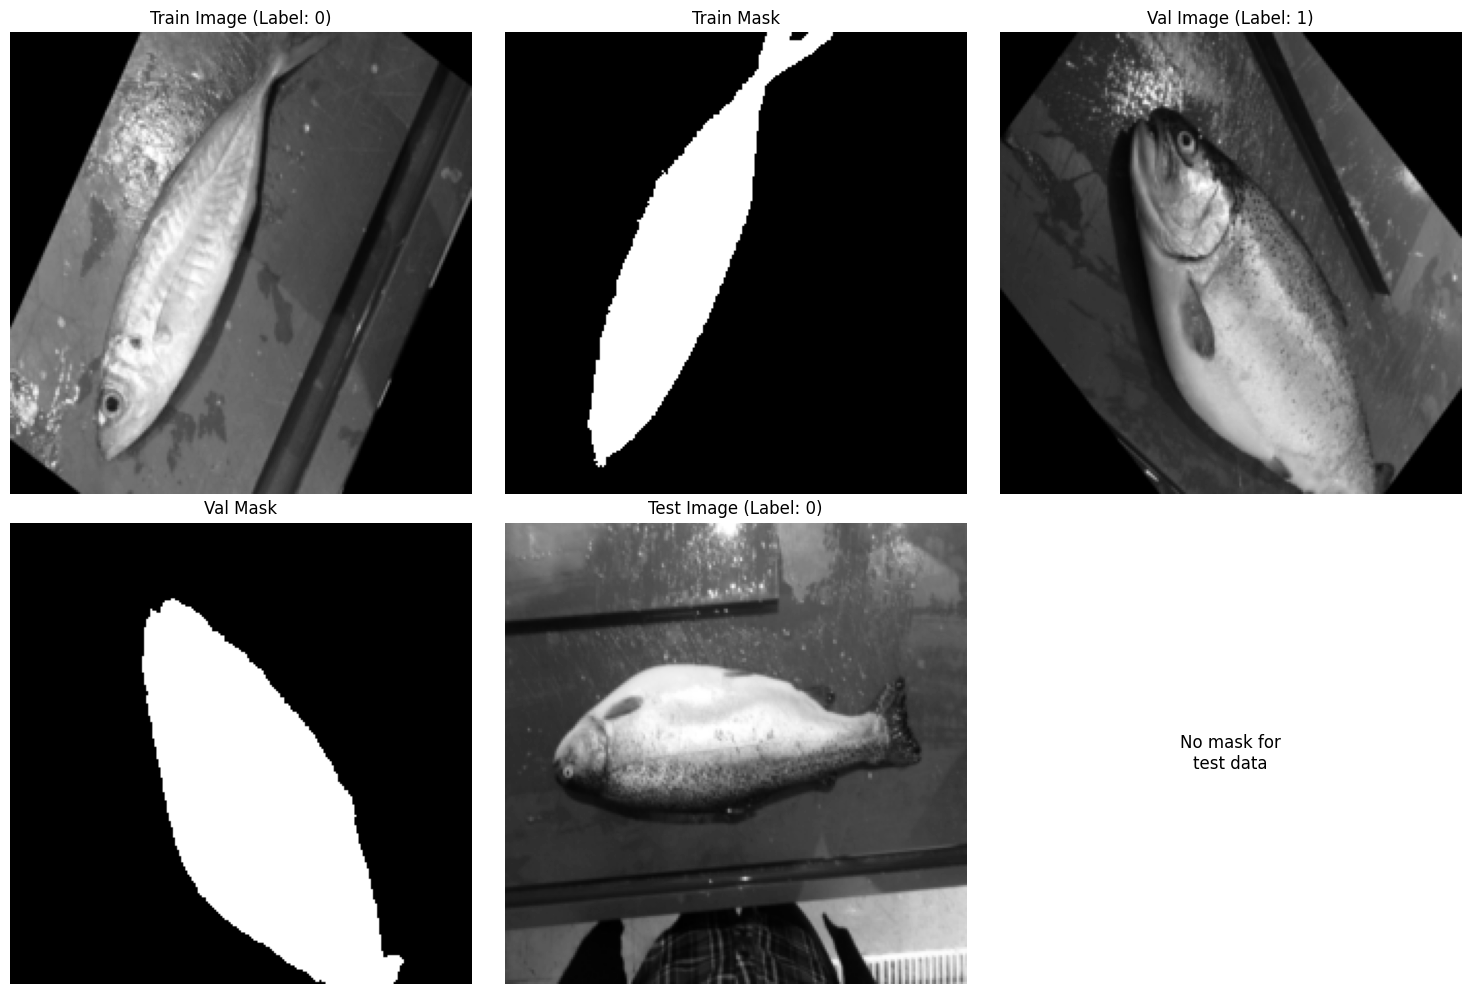

In [78]:
import matplotlib.pyplot as plt

# Test train dataloader (has masks)
train_dl, val_dl, cat = create_fish_dataloaders_separate()
train_batch = next(iter(train_dl))
print(f"Train batch: {len(train_batch)} items")
if len(train_batch) == 3:
    images, masks, labels = train_batch
    print(f"  Images: {images.shape}")
    print(f"  Masks: {masks.shape}")
    print(f"  Labels: {labels.shape}")

# Test validation dataloader (has masks)
val_batch = next(iter(val_dl))
print(f"Val batch: {len(val_batch)} items")
if len(val_batch) == 3:
    val_images, val_masks, val_labels = val_batch
    print(f"  Images: {val_images.shape}")
    print(f"  Masks: {val_masks.shape}")
    print(f"  Labels: {val_labels.shape}")
    
# Test test dataloader (no masks)
test_dl, test_cat = create_test_dataloader()
test_batch = next(iter(test_dl))
print(f"Test batch: {len(test_batch)} items")
if len(test_batch) == 2:
    test_images, test_labels = test_batch
    print(f"  Images: {test_images.shape}")
    print(f"  Labels: {test_labels.shape}")

# Create a figure with subplots to show all images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Train data
axes[0, 0].imshow(images[0].squeeze().numpy(), cmap='gray')
axes[0, 0].set_title(f'Train Image (Label: {labels[0].item()})')
axes[0, 0].axis('off')

axes[0, 1].imshow(masks[0].squeeze().numpy(), cmap='gray')
axes[0, 1].set_title('Train Mask')
axes[0, 1].axis('off')

# Validation data
axes[0, 2].imshow(val_images[0].squeeze().numpy(), cmap='gray')
axes[0, 2].set_title(f'Val Image (Label: {val_labels[0].item()})')
axes[0, 2].axis('off')

axes[1, 0].imshow(val_masks[0].squeeze().numpy(), cmap='gray')
axes[1, 0].set_title('Val Mask')
axes[1, 0].axis('off')

# Test data
axes[1, 1].imshow(test_images[0].squeeze().numpy(), cmap='gray')
axes[1, 1].set_title(f'Test Image (Label: {test_labels[0].item()})')
axes[1, 1].axis('off')

# Empty subplot
axes[1, 2].axis('off')
axes[1, 2].text(0.5, 0.5, 'No mask for\ntest data', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()